# Simulator runner

In [16]:
import matplotlib.pyplot as plt
%matplotlib notebook
from collections import defaultdict

In [2]:
from utilitysimv2 import Camera, InferenceJob, TrainingJob, MultiPeriodSimulator, fair_naive_scheduler, fair_sco_scheduler, fair_random_scheduler, inference_only_scheduler, single_camera_naive, get_optimus_fn, thief_sco_scheduler, single_camera_optimizer, get_tanh_fn, get_linear_fn, get_tanh_fn, simulator, thief_scheduler, fair_scheduler

In [3]:
train_profiles = [
(68.00, 100.92, 0),
(72.00, 51.14, 0),
(75.20, 74.22, 0),
(83.10, 207.44, 0),
(64.70, 17.91, 0),
(87.00, 100.30, 0),
(70.50, 68.04, 0),
(60.90, 26.22, 0),
(58.60, 97.26, 0),
(59.50, 21.76, 0),
(69.80, 44.00, 0),
(68.00, 49.59, 0),
(73.00, 219.19, 0),
(77.80, 125.70, 0),
(62.80, 64.54, 0),
(67.90, 53.29, 0),
(69.20, 23.23, 0),
(84.60, 201.70, 0),
(83.50, 211.34, 0),
(61.10, 18.02, 0),
(69.30, 24.61, 0),
(63.80, 26.49, 0),
(56.20, 16.38, 0),
(64.60, 19.09, 0),
(65.20, 46.56, 0),
(76.70, 30.91, 0),
(69.50, 52.43, 0),
(58.30, 25.39, 0),
(75.20, 34.01, 0),
(63.30, 40.14, 0),
(68.70, 48.39, 0),
(77.40, 108.93, 0),
(84.00, 186.64, 0),
(70.20, 39.01, 0),
(65.60, 28.55, 0),
(50.20, 15.00, 0),
(86.50, 110.82, 0),
(56.30, 53.75, 0),
(58.70, 38.64, 0),
(53.80, 33.42, 0),
(74.50, 269.82, 0),
(74.80, 87.55, 0),
(78.00, 50.23, 0),
(54.80, 19.12, 0),
(86.30, 125.32, 0),
(57.30, 31.06, 0),
(75.30, 78.57, 0),
(76.80, 141.83, 0),
(79.80, 200.14, 0),
(65.50, 28.08, 0),
(75.90, 70.68, 0),
(81.30, 65.21, 0),
(52.10, 21.93, 0),
(75.60, 29.03, 0),
(59.40, 38.94, 0),
(67.60, 137.32, 0),
(65.80, 21.98, 0),
(77.20, 69.87, 0),
(69.10, 22.27, 0),
(59.90, 37.97, 0),
(74.20, 80.85, 0),
(63.10, 33.06, 0),
(60.10, 17.07, 0),
(54.00, 15.59, 0),
(52.20, 56.11, 0),
(86.60, 367.83, 0),
(70.00, 36.71, 0),
(85.10, 112.62, 0),
(70.60, 33.53, 0),
(61.50, 36.86, 0),
(57.60, 16.92, 0),
(77.00, 54.99, 0),
(64.90, 19.71, 0),
(79.00, 77.27, 0),
(70.60, 31.76, 0),
(61.10, 19.18, 0),
(69.50, 20.81, 0),
(57.80, 14.16, 0),
(64.40, 48.67, 0),
(61.40, 21.29, 0),
(61.70, 20.47, 0),
(66.60, 23.37, 0),
(55.80, 42.05, 0),
(54.90, 18.05, 0),
(79.80, 114.54, 0),
(58.50, 52.74, 0),
(59.30, 20.81, 0),
(63.00, 25.47, 0),
(62.00, 42.15, 0),
(75.80, 120.19, 0),
(67.30, 42.25, 0),
(60.80, 58.24, 0),
(70.50, 148.33, 0),
(73.00, 30.98, 0),
(79.50, 121.01, 0),
(71.70, 33.71, 0),
(60.00, 33.52, 0),
(71.70, 57.51, 0),
(78.10, 30.76, 0),
(77.40, 87.95, 0),
(82.60, 222.61, 0),
(65.60, 39.37, 0),
(62.90, 26.53, 0),
(80.60, 236.74, 0),
(51.40, 31.29, 0),
(80.20, 125.89, 0),
(63.50, 22.59, 0),
(57.70, 34.40, 0),
(72.00, 170.99, 0),
(80.70, 415.04, 0),
(60.20, 31.56, 0),
]

In [4]:
def create_cameras(n, start_accuracy = 40):
    cameras = [] 
    profiles_per_camera = int(len(train_profiles)/n)
    for i in range(0, n):
        cameras.append(Camera(str(i),
               train_profiles[i*profiles_per_camera:(i+1)*profiles_per_camera],
               start_accuracy))
    return cameras

## Run comparison

In [6]:
data = defaultdict(dict)
allocation = defaultdict(dict)
periods_to_test = [50, 100, 200, 400, 800]
provisioned_res = 2
n_cameras = 2
num_periods = 1
start_accuracy = 40

schedulers_to_test = [(fair_random_scheduler, 'fair_random'),
                      (fair_naive_scheduler, 'fair_naive'),
                     (fair_sco_scheduler, 'fair_sco'),
                     (lambda x,y,z: thief_sco_scheduler(x,y,z,iterations=5), 'thief'),
                     (inference_only_scheduler, 'inference_only')
                     ]

for retraining_period in periods_to_test:
    print("Resources: {}".format(provisioned_res))
    for scheduler, sched_name in schedulers_to_test:
        cameras = create_cameras(n_cameras, start_accuracy)
        mps = MultiPeriodSimulator(cameras, provisioned_res, scheduler, retraining_period, num_periods = num_periods)
        results, period_allocation_log = mps.step_till_completion()
        data[retraining_period][sched_name] = results['meta']['overall_inf_mean_auc']
        allocation[retraining_period][sched_name] = period_allocation_log

50
Simulator steps done.
Job 1_train_21 is done.
Job 1_train_21 is done.
Job 1_train_21 is done.
Job 1_train_21 is done.
Job 1_train_21 is done.
Job 1_train_21 is done.
Job 1_train_21 is done.
Job 0_train_20 is done.
Job 1_train_21 is done.
Job 0_train_20 is done.
Job 1_train_21 is done.
Job 0_train_20 is done.
50
Job 1_train_21 is done.
Job 0_train_20 is done.
Simulator steps done.
Job 0_train_4 is done.
Job 0_train_4 is done.
Job 0_train_4 is done.
Job 0_train_4 is done.
Job 0_train_4 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
50
Job 1_train_21 is done.
Jo

Resources: 2
Running period 0
Running period 0
Running period 0
Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7f3504bcb208>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504c87518>: [0.5, 0.5]}
Best config for 0_inference: 0_train_4
Best config for 1_inference: 1_train_22
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f3504bcb208>: [0.0, 1.5], <utilitysimv2.InferenceJob object at 0x7f3504c87518>: [0.0, 0.5]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7f3504bcb208>: [0.0, 1.5], <utilitysimv2.InferenceJob object at 0x7f3504c87518>: [0.0, 0.5]}
Best config for 0_inference: 0_train_4
Best config for 1_inference: 1_train_22
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f3504bcb208>: [0.0, 1.5], <utilitysimv2.InferenceJob object at 0x7f3504c87518>: [0.0, 0.5]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7f3504bcb208>: [0.0, 1.5], <utilitysimv2.InferenceJob object at 0x7f3504c87518>: [0.0, 0.5]}
Best conf

Job 0_train_4 is done.
Job 0_train_4 is done.
Job 0_train_4 is done.
Job 0_train_4 is done.
Job 0_train_4 is done.
Job 0_train_4 is done.
Job 0_train_4 is done.
Job 0_train_4 is done.
Job 0_train_4 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 1_train_22 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 0_train_4 is done.
Job 1_train_22 is done.
Job 0_train_4 is 

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f3504bcb208>: [0.0, 1.5], <utilitysimv2.InferenceJob object at 0x7f3504c87518>: [0.0, 0.5]}
Running period 0
Resources: 2
Running period 0
Running period 0


Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 i

Running period 0
Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d10470>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504bcb160>: [0.5, 0.5]}
Best config for 0_inference: 0_train_4
Best config for 1_inference: 1_train_21
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d10470>: [0.5, 0.4], <utilitysimv2.InferenceJob object at 0x7f3504bcb160>: [0.5, 0.6]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d10470>: [0.5, 0.4], <utilitysimv2.InferenceJob object at 0x7f3504bcb160>: [0.5, 0.6]}
Best config for 0_inference: 0_train_4
Best config for 1_inference: 1_train_21
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d10470>: [0.5, 0.4], <utilitysimv2.InferenceJob object at 0x7f3504bcb160>: [0.5, 0.6]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d10470>: [0.5, 0.4], <utilitysimv2.InferenceJob object at 0x7f3504bcb160>: [0.5, 0.6]}
Best config for 0_inference: 0_train_4
Best config for 1

Job 1_train_21 is done.
Job 1_train_21 is done.
Job 1_train_21 is done.
Job 1_train_21 is done.
Job 1_train_21 is done.
Job 1_train_21 is done.
Job 1_train_21 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
50
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_train_4 is done.
Job 1_train_21 is done.
Job 0_

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d10470>: [0.5, 0.4], <utilitysimv2.InferenceJob object at 0x7f3504bcb160>: [0.5, 0.6]}
Running period 0
Resources: 2
Running period 0
Running period 0


Job 0_train_51 is done.
Job 1_train_18 is done.
150
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_18 is done.
Job 0_train_51 is done.
Job 1_train_

Running period 0


50
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_4

Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7f3504be9b38>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504d36b38>: [0.5, 0.5]}
Best config for 0_inference: 0_train_53
Best config for 1_inference: 1_train_43
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f3504be9b38>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504d36b38>: [0.5, 0.5]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7f3504be9b38>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504d36b38>: [0.5, 0.5]}
Best config for 0_inference: 0_train_53
Best config for 1_inference: 1_train_43
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f3504be9b38>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504d36b38>: [0.5, 0.5]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7f3504be9b38>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504d36b38>: [0.5, 0.5]}
Best config for 0_inference: 0_train_53
Best config for 1_inference: 1_

50
Job 0_train_53 is done.
Job 0_train_53 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_5

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f3504be9b38>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504d36b38>: [0.5, 0.5]}


Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 is done.
Job 1_train_43 is done.
Job 0_train_53 i

Running period 0
Resources: 2
Running period 0


Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
300
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.


Running period 0


Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Running period 0


50
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
100
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 1_tra

Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
300
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_train_5 is done.
Job 1_train_43 is done.
Job 0_tra

Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d171d0>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504c90470>: [0.5, 0.5]}
Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_43
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d171d0>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504c90470>: [0.5, 0.5]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d171d0>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504c90470>: [0.5, 0.5]}
Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_43
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d171d0>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504c90470>: [0.5, 0.5]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d171d0>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504c90470>: [0.5, 0.5]}
Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_

50
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_2

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d171d0>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504c90470>: [0.5, 0.5]}


Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 i

Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
350
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_

Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
350
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_t

Running period 0
Resources: 2
Running period 0


Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train

Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train

Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_train_0 is done.
Job 0_train_0 is done.
750
Job 1_train_0 is done.
Job 0_train_0 is done.
Job 1_t

Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
450
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_t

Running period 0


Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
500
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_t

Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_10 is done.
Job 0_train_5 is done.
Job 1_train_1

Running period 0


50
100
150
200
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_t

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
400
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_tra

Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5

Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
750
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_train_12 is done.
Job 0_train_5 is done.
Job 1_tra

Running period 0
Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d17668>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504cec518>: [0.5, 0.5]}
Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_43
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d17668>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504cec518>: [0.5, 0.5]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d17668>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504cec518>: [0.5, 0.5]}
Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_train_43
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d17668>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504cec518>: [0.5, 0.5]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d17668>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504cec518>: [0.5, 0.5]}
Best config for 0_inference: 0_train_25
Best config for 1_inference: 1_

50
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_4

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f3504d17668>: [0.5, 0.5], <utilitysimv2.InferenceJob object at 0x7f3504cec518>: [0.5, 0.5]}


Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 i

Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 i

Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
550
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_

Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 is done.
Job 1_train_43 is done.
Job 0_train_25 i

Running period 0


In [7]:
data

defaultdict(dict,
            {50: {'fair_random': 20.0,
              'fair_naive': 25.204885012453538,
              'fair_sco': 31.06443927478658,
              'thief': 41.034007770922095,
              'inference_only': 40.0},
             100: {'fair_random': 20.0,
              'fair_naive': 42.402709667408125,
              'fair_sco': 42.402709667408125,
              'thief': 49.081017222105274,
              'inference_only': 40.0},
             200: {'fair_random': 20.0,
              'fair_naive': 37.53005283055592,
              'fair_sco': 59.88197970387873,
              'thief': 60.01392331815106,
              'inference_only': 40.0},
             400: {'fair_random': 39.41425567573421,
              'fair_naive': 50.9677171934814,
              'fair_sco': 61.8151546991227,
              'thief': 68.68699852524273,
              'inference_only': 40.0},
             800: {'fair_random': 53.607170036332356,
              'fair_naive': 47.82692239011425,
              

# Visualization

### Comparison

In [7]:
data[1]

{'fair_random': 10.0,
 'fair_naive': 32.965016510513436,
 'fair_sco': 26.189008911007278,
 'thief': 34.24221960146635,
 'inference_only': 20.0}

([<matplotlib.axis.XTick at 0x7ffb432fb710>,
 <a list of 5 Text xticklabel objects>)

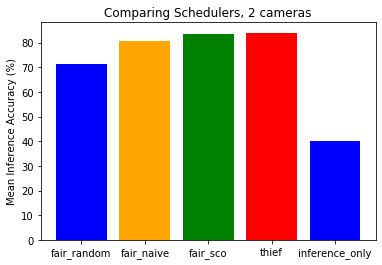

In [8]:
res = 5
plt.ylabel('Mean Inference Accuracy (%)')
plt.title('Comparing Schedulers, 2 cameras')
plt.bar(range(len(data[res])), list(data[res].values()), align='center',  color=['blue', 'orange', 'green', 'red'])
plt.xticks(range(len(data[res])), list(data[res].keys()))

<IPython.core.display.Javascript object>


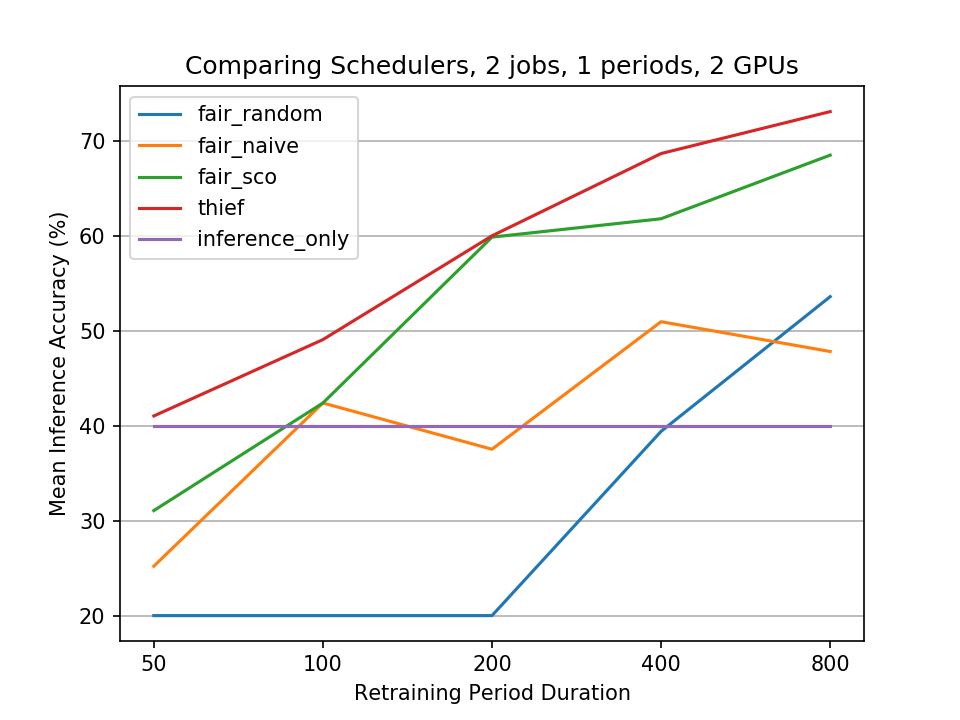

{'fair_random': {'period': [50, 100, 200, 400, 800], 'acc': [20.0, 20.0, 20.0, 39.41425567573421, 53.607170036332356]}, 'fair_naive': {'period': [50, 100, 200, 400, 800], 'acc': [25.204885012453538, 42.402709667408125, 37.53005283055592, 50.9677171934814, 47.82692239011425]}, 'fair_sco': {'period': [50, 100, 200, 400, 800], 'acc': [31.06443927478658, 42.402709667408125, 59.88197970387873, 61.8151546991227, 68.51876269687173]}, 'thief': {'period': [50, 100, 200, 400, 800], 'acc': [41.034007770922095, 49.081017222105274, 60.01392331815106, 68.68699852524273, 73.10599673521645]}, 'inference_only': {'period': [50, 100, 200, 400, 800], 'acc': [40.0, 40.0, 40.0, 40.0, 40.0]}}
{'fair_random': {'period': [50, 100, 200, 400, 800], 'acc': [20.0, 20.0, 20.0, 39.41425567573421, 53.607170036332356]}, 'fair_naive': {'period': [50, 100, 200, 400, 800], 'acc': [25.204885012453538, 42.402709667408125, 37.53005283055592, 50.9677171934814, 47.82692239011425]}, 'fair_sco': {'period': [50, 100, 200, 400, 8

In [20]:
plt.figure()
scheduler_wise_data = {k: {"period": [], "acc": []} for k in data[50].keys()}
for period in data.keys():
    for sched in data[period].keys():
        scheduler_wise_data[sched]["period"].append(period)
        scheduler_wise_data[sched]["acc"].append(data[period][sched])
print(scheduler_wise_data)
for sched in scheduler_wise_data:
    plt.plot(range(len(periods_to_test)), scheduler_wise_data[sched]["acc"], label=sched)
plt.xlabel('Retraining Period Duration')
plt.ylabel('Mean Inference Accuracy (%)')
plt.title('Comparing Schedulers, 2 jobs, {} periods, {} GPUs'.format(num_periods, provisioned_res))
plt.legend()
plt.xticks(range(0, len(periods_to_test)), periods_to_test)
plt.gca().yaxis.grid(True)

print(scheduler_wise_data)

In [10]:
data_instacp={'fair_worst': 29.690015550093747,
 'fair_smart': 50.643793494072995,
 'thief': 65.95741850672249,
 'inference_only': 15.000000000000002}

data_nocp={'fair_worst': 7.5,
 'fair_smart': 39.031395653312515,
 'thief': 51.776637679714945,
 'inference_only': 15.0}

combined_data = defaultdict(list)

combined_data = {k: [data[k], data_nocp[k]] for k in data.keys()}
print(combined_data)

KeyError: 1

In [ ]:
import numpy as np

labels = ['Always Checkpointing', 'EndOnly Checkpointing'] # [5, 30, 200], [150, 300, 200]

x = np.arange(len(labels))  # the label locations

num_bars = len(combined_data.keys())
width = 0.7/num_bars
x_pos = np.arange(-1*num_bars*width/2, num_bars*width/2, width)

fig, ax = plt.subplots()
for i, (label, values) in enumerate(combined_data.items()):
    ax.bar(x + x_pos[i], values, width, label=label, zorder=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Inference Accuracy (%)')
ax.set_title('Comparing Schedulers vs Checkpointing Method, 2 cameras')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center')

fig.tight_layout()
plt.grid(axis='y', zorder=0)

plt.show()

### Accuracy progression

In [ ]:
plt.figure()
for job, result in results.items():
    if job != 'meta':
        t, acc = list(zip(*result))
        plt.plot(t, acc, label=job.name)
plt.title("Training and inference job accuracy over time")
plt.legend()
plt.xlabel("Wall time")
plt.ylabel("Accuracy")

In [ ]:
for t, allocation in sim.period_allocation.items():
    names = []
    allocs = []
    for j, alloc in allocation.items():
        allocs.append(alloc)
        names.append(j.name)
    print(names, allocs)
    plt.figure()
    plt.pie(allocs, labels=names, autopct='%1.1f%%',
        shadow=True, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title("Allocation at t = {}".format(t))

In [ ]:
means = []
for j, result in results.items():
    if isinstance(j, InferenceJob):
        mean_accuracy = sum(r[1] for r in result)/len(result)
        means.append(mean_accuracy)
MEAN_AUC = sum(means)/len(means)
print("Mean Inference Accuracy across all jobs: {}".format(MEAN_AUC))

In [ ]:
results['meta']